In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import Delaunay

Define a workspace in terms of four corners, and introduce some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

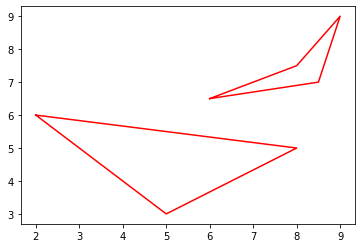

In [23]:
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]])]

def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)

for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

In [35]:
def lines_cross(a,b,c,d):
    M = np.array([[b[0]-a[0],c[0]-d[0]],[b[1]-a[1],c[1]-d[1]]])
    if np.linalg.det(M)==0.:
        return(False)
    v = np.array([[c[0]-a[0]],[c[1]-a[1]]])
    w = np.linalg.solve(M,v)
    if w[0]<=0:
        return(False)
    elif w[0]>=1:
        return(False)
    elif w[1]<=0:
        return(False)
    elif w[1]>=1:
        return(False)
    else:
        return(True)
    
def line_crosses_obst(a,b,obst):
    for ii in range(len(obst)):
        if lines_cross(a,b,obst[ii-1],obst[ii]):
            return(True)
    # extra test in case line is completely inside
    num_crosses = 0
    for ii in range(len(obst)):
        if lines_cross(0.5*(a+b),[max(obst[:,0])+0.01,max(obst[:,1])+0.01],obst[ii-1],obst[ii]):
            num_crosses = num_crosses+1
    if num_crosses%2==1:
        return(True)
    return(False)
            
def is_visible(a,b,obstacles):
    for ob in obstacles:
        if line_crosses_obst(a,b,ob):
            return(False)
    return(True)

def is_free(xlo,ylo,xhi,yhi,obstacles):
    for ob in obstacles:
        for p in ob[:]:
            if p[0]>xlo and p[0]<xhi:
                if p[1]>ylo and p[1]<yhi:
                    return(False)
    if not is_visible(np.array([xlo,ylo]),np.array([xlo,yhi]),obstacles):
        return(False)
    elif not is_visible(np.array([xlo,yhi]),np.array([xhi,yhi]),obstacles):
        return(False)
    elif not is_visible(np.array([xhi,yhi]),np.array([xhi,ylo]),obstacles):
        return(False)
    elif not is_visible(np.array([xhi,ylo]),np.array([xlo,ylo]),obstacles):
        return(False)
    else:
        return(True)
    
    

Take all vertices together - those of the workspace and of the obstacles - and run a Delaunay triangulation.  Plot it over our world to see if the edges line up.

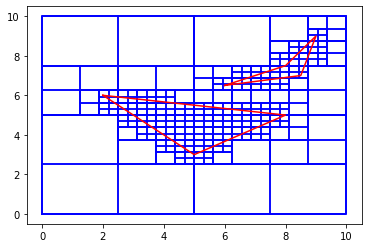

In [38]:
def quadtree(xlo,ylo,xhi,yhi,obstacles):
    #print(xlo,ylo,xhi,yhi)
    assert(xhi>xlo)
    assert(yhi>ylo)
    plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'b-')
    if is_free(xlo,ylo,xhi,yhi,obstacles):
        pass
    elif xhi>xlo+0.5:
        quadtree(xlo,ylo,0.5*(xlo+xhi),0.5*(ylo+yhi),obstacles)
        quadtree(0.5*(xlo+xhi),0.5*(ylo+yhi),xhi,yhi,obstacles)
        quadtree(xlo,0.5*(ylo+yhi),0.5*(xlo+xhi),yhi,obstacles)
        quadtree(0.5*(xlo+xhi),ylo,xhi,0.5*(ylo+yhi),obstacles)
    
bl = [0.,0.]
tr = [10.,10.]
quadtree(bl[0],bl[1],tr[0],tr[1],obstacles)

for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

They don't!  The long edge of the lower obstacle has been missed.  To fix it, we add the midpoint of the long edge to the obstacle and try again.

In [4]:
obstacles[0] = np.insert(obstacles[0],1,0.5*(obstacles[0][0]+obstacles[0][1]),0)
obstacles[0]

array([[2. , 6. ],
       [5. , 5.5],
       [8. , 5. ],
       [5. , 3. ]])

Now repeat the triangulation

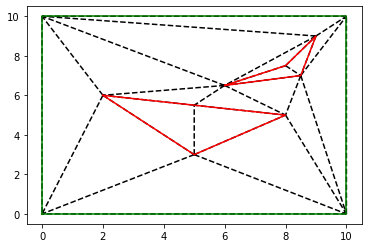

In [5]:
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
all_points = outer_points
for ob in obstacles:
    all_points = np.append(all_points,ob[:],0)
tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

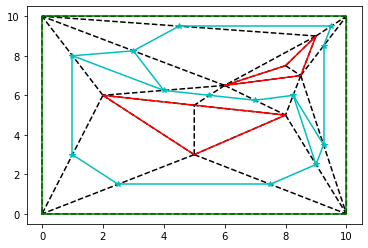

In [6]:
num_tris = len(tri.simplices)

nx_points = []
d = np.inf+np.zeros((num_tris,num_tris))
tri_nx = [[] for t in tri.simplices]
new_nx_idx = 0

for ii in range(num_tris):
    for jj in tri.neighbors[ii]:
        if jj>ii:
            common_edge = set(tri.simplices[ii]).intersection(set(tri.simplices[jj]))
            # ignore neighbour if both common vertices are shared with the same obstacle - that'd be crossing in
            # this is a hack that only works for this example - 4-7 are one obst, 8 and above are the other
            if min(common_edge)>3 and max(common_edge)<8:
                pass
            elif min(common_edge)>7:
                pass
            else:
                mid_point = sum(all_points[list(common_edge)])/2.0
                #print(mid_point)
                plt.plot(mid_point[0],mid_point[1],'c*')
                nx_points.append(mid_point)
                new_nx_idx = len(nx_points)-1
                tri_nx[ii].append(new_nx_idx)
                tri_nx[jj].append(new_nx_idx)
                for nx in tri_nx[ii]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')
                for nx in tri_nx[jj]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')

num_nx_points = len(nx_points)
d = d[0:num_nx_points,0:num_nx_points]
                    
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

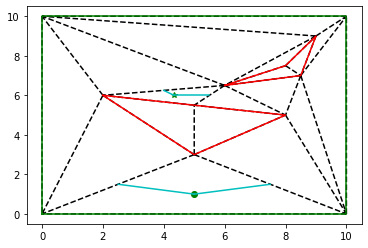

In [18]:
def append_dist_matrix(d):
    (r,c)=d.shape
    d2 = np.vstack((d,np.inf+np.zeros((1,c))))
    d3 = np.hstack((d2,np.inf+np.zeros((r+1,1))))
    return(d3)

nx_points_aug = nx_points[:]

start_tri = 1
start_point = sum(all_points[tri.simplices[start_tri]])/3.
nx_points_aug.append(start_point)
d_aug = append_dist_matrix(d)
start_idx = len(nx_points_aug)-1
plt.plot(start_point[0],start_point[1],'go')
for nx in tri_nx[start_tri]:
    plt.plot([nx_points_aug[start_idx][0],nx_points_aug[nx][0]],[nx_points_aug[start_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[start_idx,nx]=np.linalg.norm(nx_points_aug[start_idx]-nx_points_aug[nx])
    d_aug[nx,start_idx]=d_aug[start_idx,nx]

goal_tri = num_tris-6
goal_point = sum(all_points[tri.simplices[goal_tri]])/3.
nx_points_aug.append(goal_point)
d_aug = append_dist_matrix(d_aug)
goal_idx = len(nx_points_aug)-1
plt.plot(goal_point[0],goal_point[1],'g*')
for nx in tri_nx[goal_tri]:
    plt.plot([nx_points_aug[goal_idx][0],nx_points_aug[nx][0]],[nx_points_aug[goal_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[goal_idx,nx]=np.linalg.norm(nx_points_aug[goal_idx]-nx_points_aug[nx])
    d_aug[nx,goal_idx]=d_aug[goal_idx,nx]
    
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

In [19]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(d_aug, return_predecessors=True)
print(distance)
print(predecessors)

[[ 0.          5.          2.12132034  7.12132034  8.92409598 14.95487239
   9.95487239 12.50355125  9.99380163 11.51449226  7.01556444  8.473111
  13.96812686  8.96812686  4.6708301   8.88977766]
 [ 5.          0.          7.12132034 12.12132034 11.36870241  9.99890326
  10.48182954  7.78924714  4.99380163  6.51449226  2.01556444  3.473111
   8.96812686  3.96812686  9.6708301   3.88977766]
 [ 2.12132034  7.12132034  0.          5.          6.80277564 12.83355204
   7.83355204 10.3822309  12.11512197 11.65698578  9.13688478 10.59443134
  13.86432845 11.0894472   2.54950976 11.01109801]
 [ 7.12132034 12.12132034  5.          0.          1.80277564  7.83355204
   2.83355204  5.3822309   8.17767641  6.65698578 11.93443502  9.69836705
   8.86432845 13.86432845  2.54950976  9.34434308]
 [ 8.92409598 11.36870241  6.80277564  1.80277564  0.          6.03077641
   1.03077641  3.57945527  6.37490078  4.85421014 10.13165939  7.89559141
   7.06155281 12.06155281  4.35228539  7.54156744]
 [14.9548

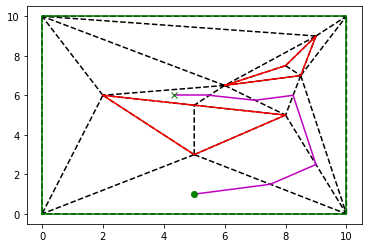

In [20]:
curr_node = start_idx
for kk in range(len(nx_points)):
    next_node = predecessors[goal_idx,curr_node]
    plt.plot([nx_points_aug[curr_node][0],nx_points_aug[next_node][0]],[nx_points_aug[curr_node][1],nx_points_aug[next_node][1]],'m-')
    curr_node=next_node
    if curr_node==goal_idx:
        break
        
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.plot(start_point[0],start_point[1],'go',goal_point[0],goal_point[1],'gx')
plt.show()

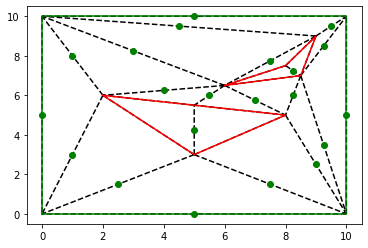

{(0.0, 5.0),
 (1.0, 3.0),
 (1.0, 8.0),
 (2.5, 1.5),
 (3.0, 8.25),
 (4.0, 6.25),
 (4.5, 9.5),
 (5.0, 0.0),
 (5.0, 4.25),
 (5.0, 10.0),
 (5.5, 6.0),
 (7.0, 5.75),
 (7.5, 1.5),
 (7.5, 7.75),
 (8.25, 6.0),
 (8.25, 7.25),
 (9.0, 2.5),
 (9.25, 3.5),
 (9.25, 8.5),
 (9.5, 9.5),
 (10.0, 5.0)}

In [10]:
midpoints = [0.5*(tri.points[a]+tri.points[b]) for (a,b,c) in tri.simplices]
midpoints = midpoints+[0.5*(tri.points[a]+tri.points[c]) for (a,b,c) in tri.simplices]
midpoints = midpoints+[0.5*(tri.points[b]+tri.points[c]) for (a,b,c) in tri.simplices]
# remove duplicates - likely to have every point twice!
midpoints = set([(m[0],m[1]) for m in midpoints])

# and remove the midpoints of the obstacle walls
for ob in obstacles:
    for ii in range(len(ob)):
        p2 = ob[ii]
        p1 = ob[ii-1]
        pm = 0.5*(p1+p2)
        midpoints.remove((pm[0],pm[1]))

plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.plot([m[0] for m in midpoints],[m[1] for m in midpoints],'go')
plt.show()

midpoints

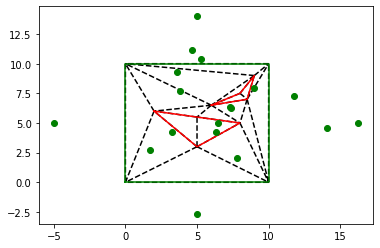

In [11]:
def circumcentre(a,b,c):
    R = np.array([[0.,1.],[-1.,0.]])
    abr=np.dot(R,a-b)
    acr=np.dot(R,a-c)
    M = np.hstack((np.vstack((np.eye(2),np.eye(2))),np.vstack((abr[0],abr[1],0.,0.)),np.vstack((0.,0.,acr[0],acr[1]))))
    abm = 0.5*(a+b)
    acm = 0.5*(a+c)
    v = np.vstack((abm[0],abm[1],acm[0],acm[1]))
    r = np.linalg.solve(M,v)
    return(r[0:2])
ccs = [circumcentre(tri.points[a],tri.points[b],tri.points[c]) for (a,b,c) in tri.simplices]

plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.plot([p[0] for p in ccs],[p[1] for p in ccs],'go')
plt.show()


In [12]:
ob_edges-tri_edges

NameError: name 'ob_edges' is not defined